# Data Mining Techniques


## Importing of neccessary libraries


Note use python 3.11.7 for stability


In [1]:
!pip install Orange3
!pip install apyori
!pip install mlxtend
!pip install pycaret



Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.2
    Uninstalling scikit-learn-1.4.2:
      Successfully uninstalled scikit-learn-1.4.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.6.1 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl (10.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orange3 3.38.1 requires scikit-learn>=1.5.1, but you have scikit-learn 1.4.2 which is incompatible.


In [11]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import apyori
from mlxtend.frequent_patterns import apriori, association_rules    
import pycaret
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules


# Here i am getting the data set

In [7]:
# Load the data
df1 = pd.read_csv('bank marketing dataset 1.csv')
df2 = pd.read_csv('bank marketinf data set 2.csv')

# Split the single column into multiple columns
df1 = df1['age;job;marital;education;default;housing;loan;contact;month;day_of_week;duration;campaign;pdays;previous;poutcome;y'].str.split(';', expand=True)
df2 = df2['age;job;marital;education;default;balance;housing;loan;contact;day;month;duration;campaign;pdays;previous;poutcome;y'].str.split(';', expand=True)

# Assign column names
df1.columns = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df2.columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

# Convert appropriate columns to numeric types
df1['age'] = pd.to_numeric(df1['age'], errors='coerce')
df1['duration'] = pd.to_numeric(df1['duration'], errors='coerce')
df1['campaign'] = pd.to_numeric(df1['campaign'], errors='coerce')
df1['pdays'] = pd.to_numeric(df1['pdays'], errors='coerce')
df1['previous'] = pd.to_numeric(df1['previous'], errors='coerce')

df2['age'] = pd.to_numeric(df2['age'], errors='coerce')
df2['balance'] = pd.to_numeric(df2['balance'], errors='coerce')
df2['duration'] = pd.to_numeric(df2['duration'], errors='coerce')
df2['campaign'] = pd.to_numeric(df2['campaign'], errors='coerce')
df2['pdays'] = pd.to_numeric(df2['pdays'], errors='coerce')
df2['previous'] = pd.to_numeric(df2['previous'], errors='coerce')

# Data Shape and Types
print("DataFrame df1 shape:", df1.shape)
print("DataFrame df2 shape:", df2.shape)
print("\nDataFrame df1 data types:\n", df1.dtypes)
print("\nDataFrame df2 data types:\n", df2.dtypes)



DataFrame df1 shape: (41176, 16)
DataFrame df2 shape: (45211, 17)

DataFrame df1 data types:
 age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

DataFrame df2 data types:
 age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day          object
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


# Discretization of data 


## Here we start with Kmeans Discretization

In [8]:
# Ensure no missing values in 'age' column
df1 = df1.dropna(subset=['age'])
df2 = df2.dropna(subset=['age'])

# Convert 'age' column to numpy array for clustering
ages_df1 = np.array(df1['age']).reshape(-1, 1)
ages_df2 = np.array(df2['age']).reshape(-1, 1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df1['age_clusters'] = kmeans.fit_predict(ages_df1)
df2['age_clusters'] = kmeans.fit_predict(ages_df2)

print(df1)
print(df2)


       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41171   73      retired  married  professional.course       no     yes   no   
41172   46  blue-collar  married  professional.course       no      no   no   
41173   56      retired  married    university.degree       no     yes   no   
41174   44   technician  married  professional.course       no      no   no   
41175   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

## Next We are initializing the FP-Growth


In [20]:
# Convert df1 to a one-hot encoded DataFrame
df1_one_hot = pd.get_dummies(df1, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'])

# Retain only binary columns for FP-Growth
binary_columns = df1_one_hot.columns[df1_one_hot.isin([0, 1]).all()]  # Select columns with only 0/1 values
df1_binary = df1_one_hot[binary_columns]

# Apply FP-Growth to find frequent itemsets
frequent_itemsets = fpgrowth(df1_binary, min_support=0.5, use_colnames=True)

# Display frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Display association rules
print("\nAssociation Rules:")
print(rules)


Frequent Itemsets:
     support                                           itemsets
0   1.000000                                           (y_True)
1   0.863391                             (poutcome_nonexistent)
2   0.824218                                          (loan_no)
3   0.791165                                       (default_no)
4   0.605231                                  (marital_married)
5   0.523873                                      (housing_yes)
6   0.634714                                 (contact_cellular)
7   0.863391                     (poutcome_nonexistent, y_True)
8   0.824218                                  (loan_no, y_True)
9   0.711677                    (poutcome_nonexistent, loan_no)
10  0.711677            (loan_no, poutcome_nonexistent, y_True)
11  0.791165                               (default_no, y_True)
12  0.668545                 (default_no, poutcome_nonexistent)
13  0.651787                              (default_no, loan_no)
14  0.668545         

In [22]:
# Convert df2 to a one-hot encoded DataFrame
df2_one_hot = pd.get_dummies(df2, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'poutcome', 'y'])

# Retain only binary columns for FP-Growth
binary_columns = df2_one_hot.columns[df2_one_hot.isin([0, 1]).all()]  # Select columns with only 0/1 values
df2_binary = df2_one_hot[binary_columns]

# Apply FP-Growth to find frequent itemsets
frequent_itemsets = fpgrowth(df2_binary, min_support=0.5, use_colnames=True)

# Display frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Display association rules
print("\nAssociation Rules:")
print(rules)


Frequent Itemsets:
     support                                           itemsets
0   1.000000                                           (y_True)
1   1.000000                                        (loan_True)
2   1.000000                                     (housing_True)
3   1.000000                                     (default_True)
4   0.817478                                 (poutcome_unknown)
..       ...                                                ...
74  0.647741  (housing_True, loan_True, default_True, contac...
75  0.647741  (housing_True, default_True, contact_cellular,...
76  0.647741  (loan_True, default_True, contact_cellular, y_...
77  0.647741  (housing_True, loan_True, contact_cellular, y_...
78  0.647741  (loan_True, contact_cellular, default_True, ho...

[79 rows x 2 columns]

Association Rules:
                          antecedents  \
0                         (loan_True)   
1                            (y_True)   
2                      (housing_True)   
3     

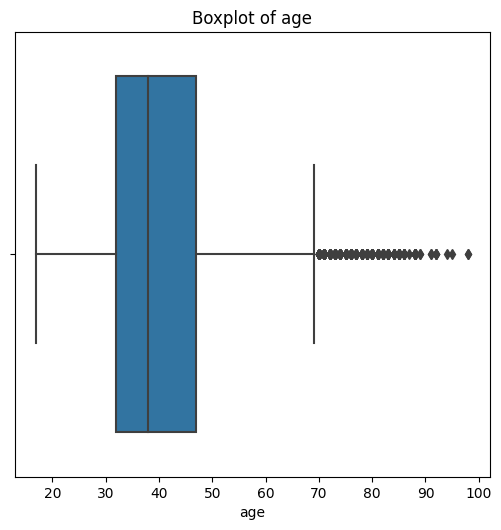

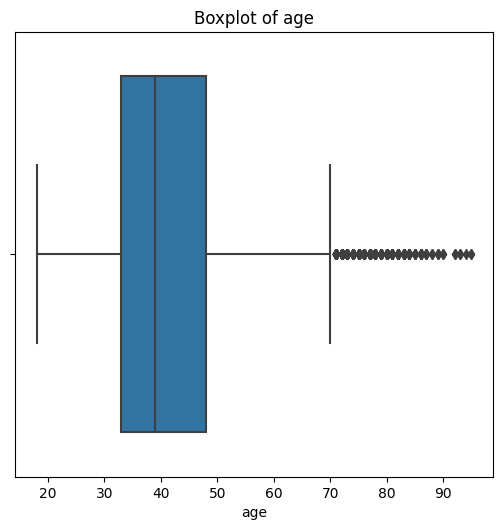

In [9]:
# Numerical features
numerical_features = ['age']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df1[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Numerical features
numerical_features = ['age']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df2[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [ ]:
# Ensure no missing values in 'age' column
df1 = df1.dropna(subset=['age','pdays','day','previous'])
df2 = df2.dropna(subset=['age','pdays','day','previous'])

# Convert 'age' column to numpy array for clustering
ages_df1 = np.array(df1['age','pdays','day','previous']).reshape(-1, 1)
ages_df2 = np.array(df2['age','pdays','day','previous']).reshape(-1, 1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df1['age_clusters'] = kmeans.fit_predict(ages_df1)
df2['age_clusters'] = kmeans.fit_predict(ages_df2)

print(df1)
print(df2)